## Importing library

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras
import sys
sys.path.append("../test/data_preprocess.py")
sys.path.append("../test/confusion_matrix.py")
from data_preprocess import load_data
from confusion_matrix import confusion_matrix

D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

## Loding data

In [2]:
para = [20,50]
X_train_temp, X_test_temp, y_train, y_test = load_data(para)
print(X_train_temp.shape, y_train.shape)
print(X_test_temp.shape, y_test.shape)

(7352, 128, 12) (7352, 6)
(2947, 128, 12) (2947, 6)


## Function

In [3]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()
    plt.clf()

# Neural Network

In [4]:
from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout,Flatten,Conv2D,MaxPooling2D,Flatten,LSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

In [5]:
sample = len(X_train_temp)
train_row = len(X_train_temp[0])
train_col = len(X_train_temp[0][0])
channel = 1
validation_split = 0.15
print(sample, train_row, train_col, channel)

7352 128 12 1


## RNN model

In [6]:
# model_RNN = Sequential()
# model_RNN.add(LSTM(64, input_shape=(train_row, train_col)))
# model_RNN.add(Dropout(0.5))
# model_RNN.add(Dense(6, activation='softmax'))
# model_RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# model_RNN.summary()

In [7]:
# X_train = X_train_temp
# X_test  = X_test_temp
# history = model_RNN.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=15)

In [8]:
# show_train_history(history, 'accuracy', 'val_accuracy')
# show_train_history(history, 'loss', 'val_loss')

In [9]:
# score = model_RNN.evaluate(X_test, y_test)
# print("test accuracy: ", score[1])
# print(confusion_matrix(y_test, model_RNN.predict(X_test)))

## CNN model

In [10]:
model_CNN = Sequential()

model_CNN.add(Conv2D(filters=16, kernel_size=(13,6), strides=(1,3),  input_shape=(train_row, train_col, channel)))
model_CNN.add(Activation('relu'))
model_CNN.add(BatchNormalization(momentum=0.8))
model_CNN.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

model_CNN.add(Conv2D(filters=32, kernel_size=(13,3), strides=(1,1)))
model_CNN.add(Activation('relu'))
model_CNN.add(BatchNormalization(momentum=0.8))
model_CNN.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

model_CNN.add(Conv2D(filters=64, kernel_size=(12,1), strides=(1,1)))
model_CNN.add(Activation('relu'))
model_CNN.add(BatchNormalization(momentum=0.8))
model_CNN.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

model_CNN.add(Dropout(0.5))
model_CNN.add(Flatten())
model_CNN.add(Dense(6, activation='softmax'))
model_CNN.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_CNN.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 116, 3, 16)        1264      
_________________________________________________________________
activation_1 (Activation)    (None, 116, 3, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 116, 3, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 3, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 1, 32)         20000     
_________________________________________________________________
activation_2 (Activation)    (None, 46, 1, 32)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 1, 32)       

In [11]:
X_train = X_train_temp.reshape(X_train_temp.shape[0],X_train_temp.shape[1],X_train_temp.shape[2],1)
X_test  = X_test_temp.reshape(X_test_temp.shape[0],X_test_temp.shape[1],X_test_temp.shape[2],1)

history = model_CNN.fit(X_train, y_train, validation_split=validation_split, batch_size=64, epochs=45)


Train on 6249 samples, validate on 1103 samples
Epoch 1/45
6249/6249 [==============================] - 6s 937us/step - loss: 0.5162 - accuracy: 0.8181 - val_loss: 0.3669 - val_accuracy: 0.9148
Epoch 2/45
6249/6249 [==============================] - 7s 1ms/step - loss: 0.1463 - accuracy: 0.9421 - val_loss: 0.3656 - val_accuracy: 0.8849
Epoch 3/45
6249/6249 [==============================] - 6s 906us/step - loss: 0.1324 - accuracy: 0.9523 - val_loss: 0.4247 - val_accuracy: 0.9084
Epoch 4/45
6249/6249 [==============================] - 5s 877us/step - loss: 0.1149 - accuracy: 0.9549 - val_loss: 0.3266 - val_accuracy: 0.9202
Epoch 5/45
6249/6249 [==============================] - 5s 879us/step - loss: 0.1034 - accuracy: 0.9525 - val_loss: 0.3602 - val_accuracy: 0.9057
Epoch 6/45
6249/6249 [==============================] - 5s 878us/step - loss: 0.1055 - accuracy: 0.9541 - val_loss: 0.3468 - val_accuracy: 0.9093
Epoch 7/45
6249/6249 [==============================] - 5s 880us/step - loss:

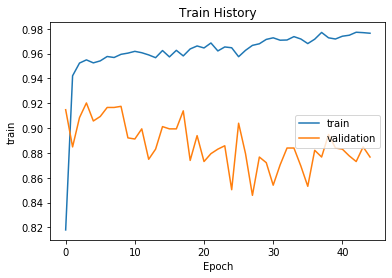

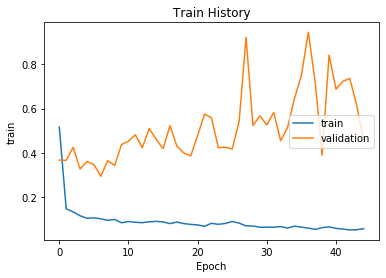

<Figure size 432x288 with 0 Axes>

In [12]:
show_train_history(history, 'accuracy', 'val_accuracy')
show_train_history(history, 'loss', 'val_loss')

In [13]:
score = model_CNN.evaluate(X_test, y_test)
print("test accuracy: ", score[1])
print(confusion_matrix(y_test, model_CNN.predict(X_test)))

2947/2947 [==============================] - 1s 258us/step
test accuracy:  0.9185612201690674
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 522        0        15        0                   0   
SITTING                  0      428        38        0                   0   
STANDING                 0       88       441        0                   0   
WALKING                  0        0         2      460                  25   
WALKING_DOWNSTAIRS       0        0         0        2                 417   
WALKING_UPSTAIRS         0        3         0       11                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                           25  
STANDING                           3  
WALKING                            9  
WALKING_DOWNSTAIRS                 1  
WALKING_